<img src="http://oci02.img.iteso.mx/identidad_de_instancia_2018/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg">

<center><font color=#555555><font size=6> Ingeniería Financiera </font> <br> <br>

<center><font color=#555555><font size=5> PAP </font> <br> <br> <br>

<center><font color=#555555><font size=5> I.F. Renatta García Sánchez </font> <br> <br>
   
<center> <font color= #555555> <font size = 4> Mayo 2020 </a> | <font color= #555555> <font size = 4> Repositorio: <a href='https://github.com/renattaGS/PAP-ML-ETICO'>Link</a></font>

<br>

---

<br>

<br>

<center> <font color= #555555> <font size = 6> Machine Learning ético </font> <br> <br> <font color= #555555>  </font>

# <font color= #555555> <font size = 5> Abstract </font>

<font color= #6B6B6B> <font size = 2> Este documento fue elaborado por Renatta García Sánchez, como trabajo para el proyecto de aplicación profesional: OPTIMIZACIÓN DE PROGRAMAS DE INVERSIÓN EN INTERMEDIARIOS FINANCIEROS, la cuál es parte del currículum de la licenciatura en Ingeniería Financiera, ofertada por la universidad **ITESO**. En el presente trabajo, se plantea la respuesta a la siguiente pregunta: </font> 

<br>

# <font color= #6B6B6B> <font size = 6> 0. Librerías y Dependencias </font>

<hr style="border:0.02in solid gray"> </hr>

# <font color= #6B6B6B> <font size = 5> 0.1 Librerías </font> <font color= #555555>

Para correr este notebook es necesario tener instaladas y/o en el archivo _requirements.txt_ las siguientes librerías :

- pandas>=1.1.1 
- pandas-profiling>=2.11.0
- jupyter>=1.0.0
- numpy>= 1.19.1
- statsmodels>=0.11.1
- openpyxl>=3.0.5
- matplotlib>=3.3.1
- scikit-learn>=0.23.2
- seaborn>=0.1.1


# <font color= #6B6B6B> <font size = 5> 0.2 Dependencias </font> <font color= #555555>

Para correr este notebook es necesario contar con los siguientes archivos y dependencias externas:

- files/Datos_Techo_converted.xlsx : Datos sobre encuesta para el programa de hábitat de la organización Techo México. 
- files/Data_techo_llenado.csv: Datos originales más datos rellenados 
- files/Data_techo_solollenado.csv: Unícamente datos relleandos
- files/Data_techo_solollenado.csv: Tabla con mejores parámetros alpha y lambada para los modelos

<br>

# <font color= #6B6B6B> <font size = 6> 1. Introducción </font>

<hr style="border:0.02in solid gray"> </hr>

<br>

# <font color= #6B6B6B> <font size = 6> 2. Objetivos </font>

<hr style="border:0.02in solid gray"> </hr>

<br>

# <font color= #6B6B6B> <font size = 6> 3. Datos </font>

<hr style="border:0.02in solid gray"> </hr>

Los datos con los que se trabajará, corresponde a las **Encuestas de Caracterización de Hogares (ECHS)**, correspondientes a los años 2019 y 2020 de la ONG Techo México. Éstas encuestas se realizan para determinar si una familia es candidata o no, a recibir un apoyo del programa de viviendas. Para determinar esto, se contemplan un total de 97 variables. Con excepción del año de aplicación de la ECHS, todas las variables son de tipo discreto para proteger la información que éstas contienen.

# <font color= #6B6B6B> <font size = 6> 4. Procesos </font>

<hr style="border:0.02in solid gray"> </hr>

## Lectura de datos

Para esta etapa del proceso haremos la lectura de tres archivos, los datos originales, los datos originales más los rellenados y finalmente únicamente los datos relleandos. Esto con el propósito de presentar tres opciones de modelo distintas para la selección del modelo final. 

En la siguiente sección se explica el método de llenado de los datos.

In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics
import tabulate
import pandas as pd
import numpy as np
import data
import functions
import visualizations

# data import
file_path = 'files/Datos_Techo_converted.xlsx'
file_path_l = 'files/Data_techo_llenado.csv'
file_path_sl = 'files/Data_techo_solollenado.csv'

data_techo = data.lectura_datos(file_path, 'Datos Techo', 'p1')
data_techo_llenado = pd.read_csv(file_path_l)
data_techo_sllenado = pd.read_csv(file_path_sl)

missing_tot = (data_techo.isnull().sum()).sum()
missing = (data_techo.isnull().sum())['p74']
percentage = missing/len(data_techo) * 100

print('Existe un total de ', missing_tot, ' datos faltantes. Estos datos '
                                          'se encuentran ubicados en la columna p74')
print('Estos datos representan el ', percentage, '% del total de registros en la base de datos.')


data_techo.drop(data_techo[data_techo['p74'].isnull()].index, inplace=True)

Existe un total de  749  datos faltantes. Estos datos se encuentran ubicados en la columna p74
Estos datos representan el  60.84484159220146 % del total de registros en la base de datos.


## Datos faltantes

Dado que existe una cantidad significativa de datos faltantes en la columna p74, tenemos que proponer una estrategia para llenar estos datos, por otro lado por el tipo de datos que tenemos, es decir socio-demográficos, no podemos sencillamente llenar con un promedio o una mediana, ya que esto sería una suposición muy grande.


Por lo tanto, tras analizar el conjunto de datos, se propone llenar estos datos faltantes particionando los datos a partir de dos criterios distintos. El primer criterio será la columna p3 y la columna p27.


A partir de ésto el DataFrame se dividará en dos, los 749 registros que tienen faltantes en la columna p74 y los que sí tienen registros. Una vez realizada ésta división, se volverán a dividir los datos de acuerdo a los valores únicos de la columna p3 y éstos últimos se dividirán una segunda vez de acuerdo a la columna p27.


Una vez realizadas estas particiones, no tomamos en cuenta aquellos que no tengan datos para ser llenados, por ejemplo si para el valor 4 de la columna p3 y el valor 3 de la columna p27 no existen datos, entonces eliminaremos las columnas que tengan datos faltantes en la p74 que concidan con este criterio, dado que no tenemos suficiente información para sustentar el llenado de ésta infofrmación.


Ahora, para los criterios con los que sí contamos con información suficiente, vamos a hacer uso de la técnica de aceptación y rechazo para generar una cantidad de datos que distribuyan como los datos con los que sí contamos. La función que usaremos para el método de aceptación y rechazo la generaremos a partir del Kernel Density Estimation de la librería de statsmodels.

### Método de aceptación y rechazo

El método de la trasnformada inversa, permite generar datos que distribuyan como una función $f(x)$. Para poder aplicar este método $f(x)$ debe de ser una función acotada y con un dominio finito $a\leq x \leq b$

De acuerdo a ésta función $f(x)$ el método propone los siguientes pasos. Asuma que podemos encontrar una función $t(x)$ tal que $$t(x)\geq f(x), \quad \forall x$$ Para este caso utilizamos $t(x)$ como el valor màximo de $f(x)$.

La función $t(x)\geq 0$ no es una PDF debido a $$\int_{-\infty}^{\infty}t(x)dx\geq \int_{-\infty}^{\infty}f(x)dx =1$$ Hacemos $T(x) = c$ $$c=\int_{-\infty}^{\infty}t(x)\geq 1$$ Definamos la función $g(x)=t(x)/c \rightarrow g(x)$ es una densidad.

Resultando entonces $$\frac{f(x)}{g(x)}\leq c,\quad \forall x$$ El siguiente algoritmo genera una variable aleatoria $X$, distribuida de acuerdo a la densidad $f(x)$
1.	Generar $R_1$ teniendo densidad $g(x)$
2.	Generar $R_2 \rightarrow U \sim U(0,1)$ independiente de $R_1$ del paso 1 .
3.	Evaluar la función de probabilidad en $R_1$.
4.	Determinar si la siguiente desigualdad se cumple: $$R_2\leq \frac{f(R_1)}{t(R_1)}$$ Si la respuesta es afirmativa se utiliza $X=R_1$, de lo contrario es necesario pasar nuevamente al paso 1, tantas veces como sea necesario.
De esta forma podemos generar una cantidad $n$ de números a partir de una distribución $f(x)$

### Kernel Density Estimation

Kernerl density estimation (KDE) es una técnica estadística no paramétrica, que nos perimite estimar la función de densidad de probabilidad de una variable. A grandes rasgos ésta técinca genera una línea suave y continua, que se ajusta a la distribución de los datos (finitos). Para hacer ésto, la técnica de KDE genera líneas a partir de los datos y se va ajustando a ellos de acuerdo a la probabilidad de ocurrencia, es decir, entre mayor presencia de datos tengamos dentro de una clase KDE, infiere que existe una mayor probabilidad de ocurrrencia de ésta clase y por lo tanto va ajustando la función de acuerdo a ésto. Una parte muy importante de KDE es el kernel, a través del parámetro bandwidth (bw), es que cambia el kernel, cuando bw es bajo, se le dará más peso a aquellos puntos que se encuentren cerca de la media, cuando bw es un valor, comienza a crecer, ésto quiere decir que se le comienza a dar más peso a los valores que se encuentran más alejados de la media.

La forma en la que se calcula ésta línea o función que genera KDE, es a través de la siguiente función:
$$ \hat{ f}(x)= \sum_{observaciones} K(\frac{x- observaciones}{bandwith}) $$
Donde K representa el kernel, el kernel hace referencia a la función de distribución que se aproxima, puede ser uniforme, guassiana, triangular, etc.
En este caso utilizamos el método de cross validation maximum likelihood (MLCV), ésta se define de la siguiente forma (MLCV) $$MLCV(h) = n^{-1} \sum_{i=1}^{n} \log\left[\hat{f}_{h,i}(x)\right]$$


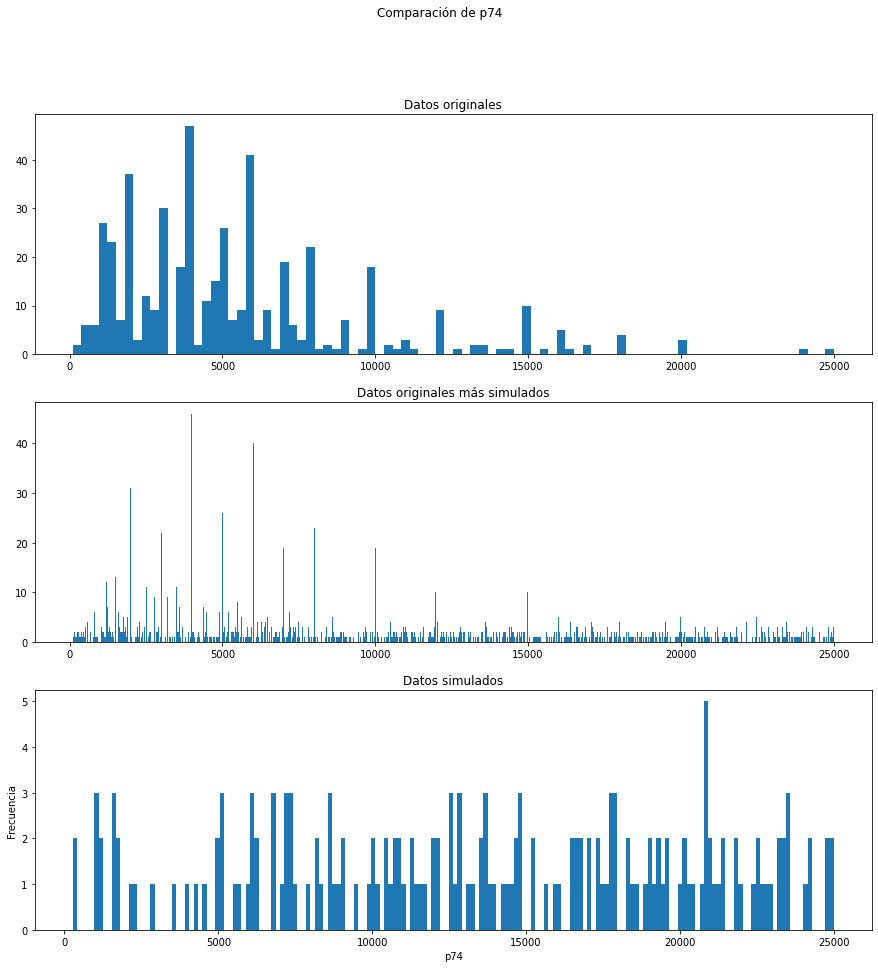

In [2]:
visualizations.plot_3_histogram(data_techo['p74'].to_numpy(), data_techo_llenado['p74'].to_numpy(),
                                data_techo_sllenado['p74'].to_numpy(), 'p74', 'Frecuencia',
                                'Comparación de p74', 'Datos originales', 
                                'Datos originales más simulados', 'Datos simulados')

En los histogramas anteriores se puede observar que los datos simulados si afectan la distribución de los datos para **p74** por lo tanto es importante tener esto en cuenta al momento de construir los modelos, porrque estos datos en particular pueden afectar la calidad de los resultados como del modelo. 

## Visualización general 

En el siguiente conjunto de gráficos podemos observar las relaciones que existen entre las variables presentadas y su relación con la variable objetivo de asignación. Estas variables que se muestran son relevantes desde un punto de vista cualitativo, ya que representan factores determinantes al momento de tomar la decisión de asignación. 

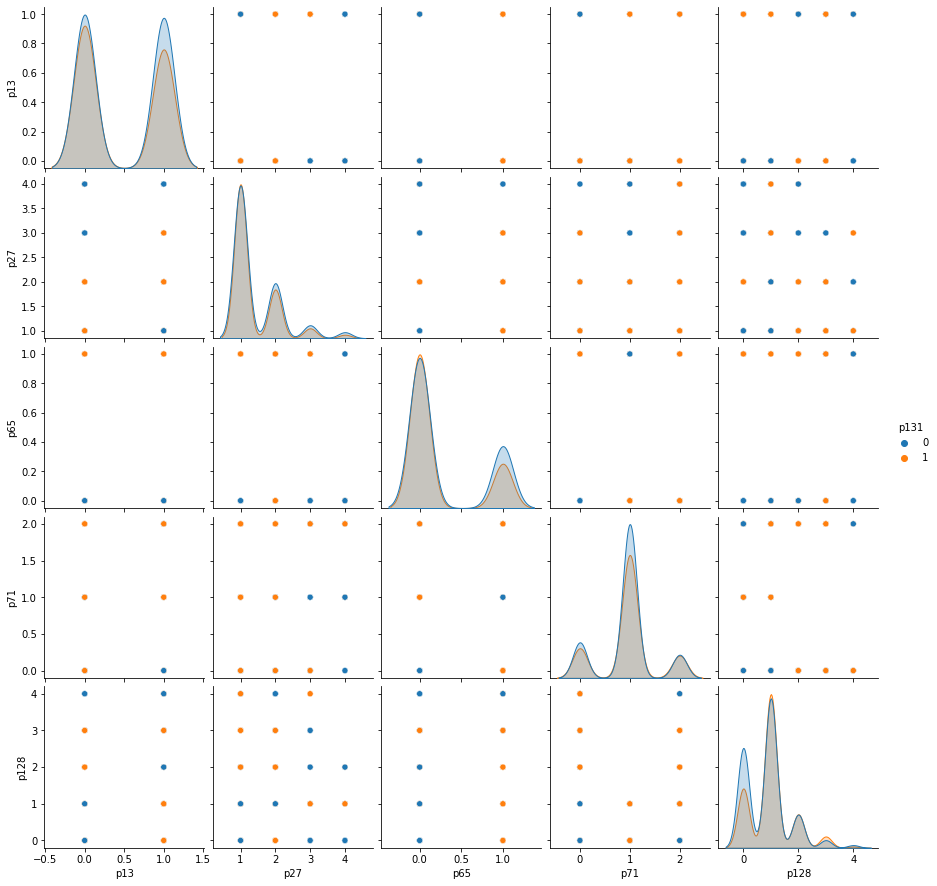

In [3]:
cols_pairplot = ['p13', 'p27', 'p65', 'p71', 'p128', 'p131']
visualizations.pairplot(data_techo_llenado, cols_pairplot, 'p131' )

## Modelado

En esta sección se realizarán todos los procedimientos necesarios para la creación de tres de regresión logística, las variables que tomaremos en cuenta para hacer éste modelo son desde p13 hasta p128 (un total de 97 variables distintas), la variable objetivo será p131. Ya se realizó un procedimiento previo para encontrar los parámetros **lambda** y **alpha** para cada uno de los modelos, con estos entrenaremos cada uno y seleccionaremos el que tenga mejores medidas de desempeño. 

In [4]:
parametros = pd.read_csv('files/parametros.csv')
parametros.drop(columns = parametros.columns[0], axis=1, inplace=True)
parametros.set_index('Datos', inplace=True)
display(parametros)

,Lambda,Alpha
Datos,,
Original,0.001,0.004
Llenados,0.001,0.021
Solo llenado,0.001,0.031


### Perparación de datos (prueba y entrenamiento)

El primer paso para la construcción de nuestro modelo, es separar los datos en prueba y entrenamiento, usaremos un 80% para prueba y un 20% para entrenamiento. Un punto importante en este paso, es cuidar la proporción con la que se dividen los datos, el enfoque de éste proyecto, nos lleva a prestar especial atención a este paso. Separaremos los datos de forma que se respete la proporción de las siguientes variables:

- p13

Un punto de alta importancia al momento de particionar los datos es buscar que ambas grupos, de entrenamiento y prueba representen correctamente todos los aspectos de la sociedad, en especial el de las minorías, ya que estas pueden llegar a carecer de representación en alguno de los conjuntos de datos generando resultados poco acertados para estos grupos. 

Para hacer ésto nos apoyaremos de la librería sklearn, que nos permite escoger las variables sobre las cuales queremos estratificar. Para el primer y tercer conjunto de datos únicamente tomaremos el 10% de los datos para realizar las pruebas, mientras que para el segundo conjunto tomaremos un 20%.

In [5]:
cols_strat = ['p13']

X_train_org, X_test_org, y_train_org, y_test_org = functions.train_test_split_strat(data_techo,
                                                                                    0.10, cols_strat)

X_train_llenado, X_test_llenado, y_train_llenado, y_test_llenado = functions.train_test_split_strat(data_techo_llenado,
                                                                                                    0.20, cols_strat)

X_train_sllenado, X_test_sllenado, y_train_sllenado, y_test_sllenado = functions.train_test_split_strat(data_techo_sllenado,
                                                                                                        0.10, cols_strat)
features = X_train_org.columns.tolist()

###  Estandirazción

Una vez particionados los datos, estandarizamos las columnas que lo requieran, ya que esta base de datos contiene muchas variables categóricas, solo es necesario estandirzar aquellas que el tipo de variable son números reales. Las variables que estandirazeremos son:


- p14
- p15
- p19
- p20
- p26
- p32
- p33
- p34
- p35
- p36
- p39
- p40
- p47
- p66
- p67
- p74
- p91
- p92
- p93
- p99
- p101
- p104

In [6]:
cols_estan = ['p14', 'p15', 'p19', 'p20', 'p26', 'p32', 'p33', 'p34', 'p35',
              'p36', 'p39', 'p40', 'p47', 'p66', 'p67', 'p74', 'p91', 'p92', 'p93',
              'p99', 'p101', 'p104']

z_train, z_test = functions.standarizacion(X_train_org, X_test_org, cols_estan)
X_train_org[cols_estan] = z_train
X_test_org[cols_estan] = z_test

z_train, z_test = functions.standarizacion(X_train_llenado, X_test_llenado, cols_estan)
X_train_llenado[cols_estan] = z_train
X_test_llenado[cols_estan] = z_test

z_train, z_test = functions.standarizacion(X_train_sllenado, X_test_sllenado, cols_estan)
X_train_sllenado[cols_estan] = z_train
X_test_sllenado[cols_estan] = z_test

### Agregamos bias a nuestra X de entrenamiento y de prueba

**Explicación

In [7]:
X_train_org['bias'] = 1
X_train_org = X_train_org[['bias'] + features].values
y_train_org = y_train_org.values
y_train_org = y_train_org.reshape(y_train_org.shape[0], 1)

X_test_org['bias'] = 1
X_test_org = X_test_org[['bias'] + features].values
y_test_org = y_test_org.values
y_test_org = y_test_org.reshape(y_test_org.shape[0], 1)

X_train_llenado['bias'] = 1
X_train_llenado = X_train_llenado[['bias'] + features].values
y_train_llenado = y_train_llenado.values
y_train_llenado = y_train_llenado.reshape(y_train_llenado.shape[0], 1)

X_test_llenado['bias'] = 1
X_test_llenado = X_test_llenado[['bias'] + features].values
y_test_llenado = y_test_llenado.values
y_test_llenado = y_test_llenado.reshape(y_test_llenado.shape[0], 1)

X_train_sllenado['bias'] = 1
X_train_sllenado = X_train_sllenado[['bias'] + features].values
y_train_sllenado = y_train_sllenado.values
y_train_sllenado = y_train_sllenado.reshape(y_train_sllenado.shape[0], 1)

X_test_sllenado['bias'] = 1
X_test_sllenado = X_test_sllenado[['bias'] + features].values
y_test_sllenado = y_test_sllenado.values
y_test_sllenado = y_test_sllenado.reshape(y_test_sllenado.shape[0], 1)

### Funciones para el entrenamiento y prueba del modelo

Función de costo: $J(w)=-\frac{1}{m} \sum_{i=1}^{m} \big( y_i\ log(\sigma(z_i)) + (1-y_i)\ log(1-\sigma(z_i)) \big) + \frac{\lambda}{2m}\sum_{j=1}^n w_j^2$

Gradiente: $\frac{\partial J(w)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m}(\sigma(z_i) - y_i) * x_i^j + \frac{\lambda}{m}w_j$

En su forma vectorizada: $\nabla J(w)=\frac{1}{m} X^T (\sigma(z) - y) + \frac{\lambda w}{m}$

Sigmoide: $\sigma(z_i) = \frac{1}{1+e^{-z_i}}$ where $z_i=x_iw^T$

Actiaulización de pesos:

* $w_0 = w_0 - \alpha \frac{1}{m}\sum_{i=1}^{m}(\sigma(z_i) - y_i)$
* $w_j = w_j - \alpha \frac{1}{m}\sum_{i=1}^{m}(\sigma(z_i) - y_i) * x_i^j + \frac{\lambda}{m}w_j$ para $j>0$

### Entrenamiento del modelo

**Explicación**

In [8]:
np.random.seed(123)
w = np.random.normal(loc=1e-3, scale=1e-6, size=(1, X_train_org.shape[1]))
epochs = 1000

w1, J1, J_t1 = functions.gd(X_train_org, y_train_org, X_test_org, y_test_org, w, parametros.loc['Original', 'Alpha'], 
                            parametros.loc['Original', 'Lambda'], epochs)
w2, J2, J_t2 = functions.gd(X_train_llenado, y_train_llenado, X_test_llenado, y_test_llenado, w, parametros.loc['Llenados', 'Alpha'], 
                            parametros.loc['Llenados', 'Lambda'], epochs)
w3, J3, J_t3 = functions.gd(X_train_sllenado, y_train_sllenado, X_test_sllenado, y_test_sllenado, w, parametros.loc['Solo llenado', 'Alpha'], 
                            parametros.loc['Solo llenado', 'Lambda'], epochs)
w1 = w1.reshape(-1)
w2 = w2.reshape(-1)
w3 = w3.reshape(-1)

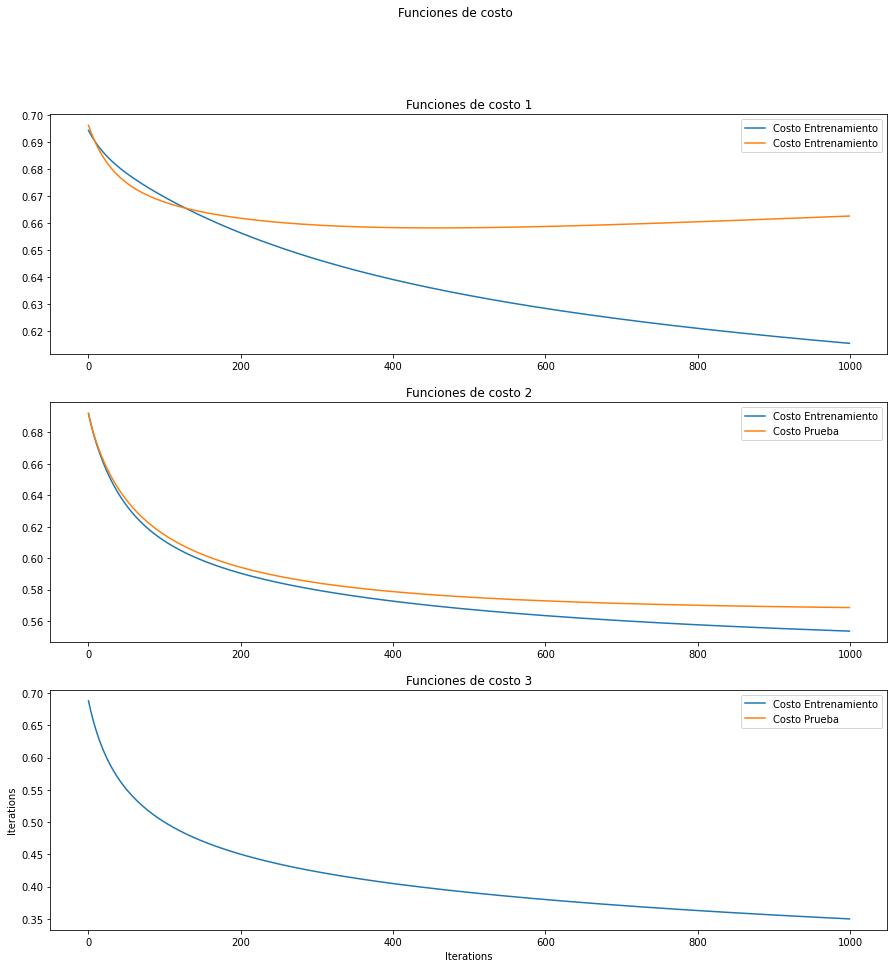

In [9]:
visualizations.plot3_cost(J1, J_t1, J2, J_t2, J3, J_t3)

### Implementamos la predicción con el modelo


En la celda siguiente, podemos observar cómo con la función h que aplica la signmoide (el clasificador utilizado) sobre nuestros datos de prueba. Ésta función nos va a regresar la probabilidad asociada a cada uno de los datos de prueba de obtener un 1 en la variable objetivo. Con esta probabilidad, establecemos un límite, es decir a partir de qué probabilidad asignaremos 1 y a partir de cuál 0. En este caso, establecemos un límite de $0.50$. Es decir que si p es mayor a $0.50$ vamos a asignar un 1, si es menor o igual a $0.50$ vamos a asignar un 0. A partir de ésto, calculamos nuestra y_hat que es la y estimada y mostramos una breve comparación de los primeros 20 resultados. La primera fila corresponde a nuestros datos reales y la segunda corresponde a los valores que usamos para probar nuestro modelo.



In [10]:
p1 = functions.h(X_train_org, w1)
y_hat1 = functions.predict(p1, 0.5)

p2 = functions.h(X_train_llenado, w2)
y_hat2 = functions.predict(p2, 0.5)

p3 = functions.h(X_train_sllenado, w3)
y_hat3 = functions.predict(p3, 0.5)

### Medidas de desempeño

Una vez hecha la predicción con nuestro modelo necesitamos saber qué tan bien o mal se desempeña el mismo, para ésto vamos a utilizar dos medidas de desempeño:

- Precisión: ésta medida nos indica la proporción de datos que fueron clasificados correctamente
- sensibilidad: ésta medida nos indica la proporción de 1, que son correctamente indentificados
- especifidad: ésta medida nos indica la proporción de 0, que son correctamente identificados


Para calcular éstas medidas, necesitamos conocer la cantidad de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN). Una vez calculados éstos valores, aplicamos la fórmula para precisión ($a_c$),  sensibilidad ($s_e$) y especifidad ($s_p$).

$$a_c = \frac{TP+ TN}{TP+ TN + FP + FN}$$

$$s_e = \frac{TP}{TP + FN}$$

$$s_p = \frac{TN}{TN + FP}$$



In [11]:
V1 = functions.get_values(y_train_org.reshape(-1), y_hat1)
V2 = functions.get_values(y_train_llenado.reshape(-1), y_hat2)
V3 = functions.get_values(y_train_sllenado.reshape(-1), y_hat3)

medidas_d = pd.DataFrame(columns=['Precisión', 'Sensibilidad', 'Especificidad'], index=parametros.index)
medidas_d['Precisión'] = [functions.accuracy(i) for i in [V1, V2, V3]]
medidas_d['Sensibilidad'] = [functions.sensitivity(i) for i in [V1, V2, V3]]
medidas_d['Especificidad'] = [functions.specificity(i) for i in [V1, V2, V3]]

display(medidas_d)

,Precisión,Sensibilidad,Especificidad
Datos,,,
Original,0.683603,0.553846,0.789916
Llenados,0.737219,0.705882,0.764933
Solo llenado,0.829114,0.827160,0.831169


# <font color= #6B6B6B> <font size = 6> 5. Conclusiones </font>

<hr style="border:0.02in solid gray"> </hr>

In [12]:
# en esta seccion es opcional incluir algun codigo para mostrar
# visualmente algun concepto o hallazgo relevante como conclusion

In [13]:
# En esta sección es opcional incluir código para mostrar/visualizar
# los datos con los que se trabajó en el laboratorio